In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error, mean_absolute_error, confusion_matrix
import torch
from torch import nn
import torch.optim as optim

# 1) Загрузка данных, очистка пропусков

In [ ]:
data = pd.read_csv("train.csv", sep=',')

print("всего пропусков:", data.isna().sum().sum())

data.head()

всего пропусков: 0


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,75516,1731.4840,411.7352,245.7620,0.8023,310.0806,0.9148,82546,0.7169,1.6753,0.3165,0.7531,0.0055,0.0033,0.5672,0.9502,1
1,98903,1374.4370,477.2451,269.7676,0.8249,354.8622,0.9585,103181,0.7679,1.7691,0.6579,0.7436,0.0048,0.0027,0.5529,0.9781,0
2,84746,1311.1570,482.7735,235.9040,0.8725,328.4843,0.9121,92914,0.7162,2.0465,0.6195,0.6804,0.0057,0.0028,0.4630,0.9474,1
3,98184,1463.1680,434.3769,292.6472,0.7390,353.5700,0.9543,102890,0.7316,1.4843,0.5763,0.8140,0.0044,0.0030,0.6625,0.9834,0
4,94170,1267.7271,440.1109,278.4162,0.7745,346.2672,0.9643,97656,0.6836,1.5808,0.7363,0.7868,0.0047,0.0030,0.6190,0.9785,0


# 2) Очистка выбросов

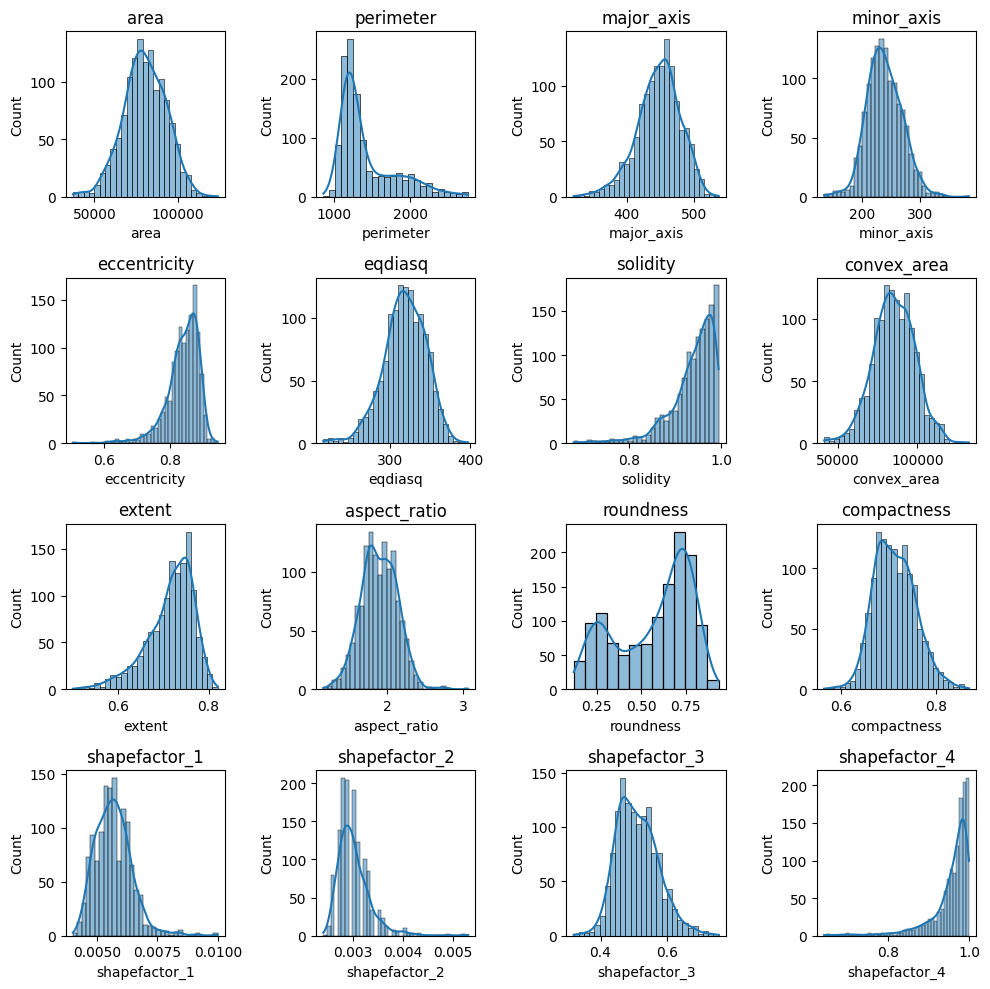

In [ ]:
plt.figure(figsize=(10, 10))
features = data.columns[:-1]
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [ ]:
data_cleaned = data.copy()
no_outliers_mask = pd.Series(True, index=data_cleaned.index)

for feature in features:
    Q1 = data_cleaned[feature].quantile(0.25)
    Q3 = data_cleaned[feature].quantile(0.75)
    IQR = Q3 - Q1
    multiplier = 2.5
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    data_cleaned.loc[(data_cleaned[feature] < lower_bound) | (data_cleaned[feature] > upper_bound), feature] = np.nan

data_cleaned.dropna(inplace=True)

print(f"Удалено выбросов: {len(data) - len(data_cleaned)}")
data = data_cleaned
data.head()

Удалено выбросов: 66


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,75516.0,1731.4840,411.7352,245.7620,0.8023,310.0806,0.9148,82546.0,0.7169,1.6753,0.3165,0.7531,0.0055,0.0033,0.5672,0.9502,1
1,98903.0,1374.4370,477.2451,269.7676,0.8249,354.8622,0.9585,103181.0,0.7679,1.7691,0.6579,0.7436,0.0048,0.0027,0.5529,0.9781,0
2,84746.0,1311.1570,482.7735,235.9040,0.8725,328.4843,0.9121,92914.0,0.7162,2.0465,0.6195,0.6804,0.0057,0.0028,0.4630,0.9474,1
3,98184.0,1463.1680,434.3769,292.6472,0.7390,353.5700,0.9543,102890.0,0.7316,1.4843,0.5763,0.8140,0.0044,0.0030,0.6625,0.9834,0
4,94170.0,1267.7271,440.1109,278.4162,0.7745,346.2672,0.9643,97656.0,0.6836,1.5808,0.7363,0.7868,0.0047,0.0030,0.6190,0.9785,0


# 3) Нормализация данных и разбиение выборки

In [ ]:
cols = data.columns[:-1].tolist()
scaler = StandardScaler()
data[cols] = scaler.fit_transform(data[cols])

x = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

data.head()

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,-0.410013,1.009302,-1.163463,0.295951,-0.983227,-0.371104,-0.884036,-0.203676,-0.071083,-1.046941,-1.369541,0.926012,-0.214978,1.267667,0.913286,-0.404379,1
1,1.447461,-0.045642,0.948216,1.149799,-0.446283,1.393581,0.303955,1.424886,1.010184,-0.624522,0.344366,0.700394,-1.204175,-1.044406,0.677868,0.443978,0
2,0.323065,-0.232611,1.126421,-0.054686,0.684627,0.354121,-0.957436,0.614591,-0.085924,0.624722,0.151589,-0.800557,0.067650,-0.659060,-0.802134,-0.489519,1
3,1.390356,0.216526,-0.433619,1.963596,-2.487147,1.342660,0.189778,1.401919,0.240576,-1.907091,-0.065285,2.372340,-1.769431,0.111630,2.482186,0.605135,0
4,1.071550,-0.360931,-0.248787,1.457418,-1.643717,1.054883,0.461629,0.988840,-0.777087,-1.472513,0.737952,1.726361,-1.345489,0.111630,1.766056,0.456140,0


# 4) Обучение модели

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

input_dim = X_train_tensor.shape[1]
model = Classifier(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {loss.item():.4f}')

Эпоха [20/500], Потери: 0.1657
Эпоха [40/500], Потери: 0.1140
Эпоха [60/500], Потери: 0.1006
Эпоха [80/500], Потери: 0.0976
Эпоха [100/500], Потери: 0.0955
Эпоха [120/500], Потери: 0.0938
Эпоха [140/500], Потери: 0.0923
Эпоха [160/500], Потери: 0.0909
Эпоха [180/500], Потери: 0.0893
Эпоха [200/500], Потери: 0.0877
Эпоха [220/500], Потери: 0.0860
Эпоха [240/500], Потери: 0.0840
Эпоха [260/500], Потери: 0.0818
Эпоха [280/500], Потери: 0.0795
Эпоха [300/500], Потери: 0.0772
Эпоха [320/500], Потери: 0.0750
Эпоха [340/500], Потери: 0.0729
Эпоха [360/500], Потери: 0.0707
Эпоха [380/500], Потери: 0.0686
Эпоха [400/500], Потери: 0.0662
Эпоха [420/500], Потери: 0.0636
Эпоха [440/500], Потери: 0.0609
Эпоха [460/500], Потери: 0.0582
Эпоха [480/500], Потери: 0.0556
Эпоха [500/500], Потери: 0.0531


# 5) Анализ эффективности

Точность = 0.9224
Полнота = 0.9375
MSE = 0.0776
MAE = 0.0776


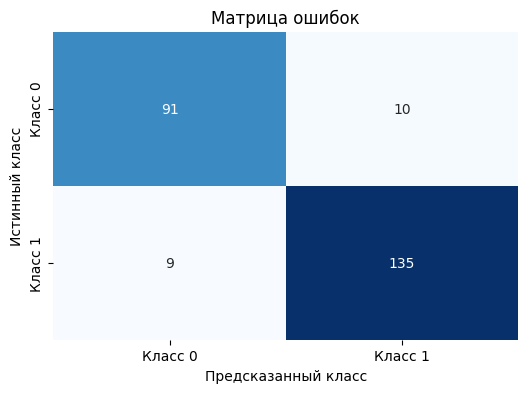

In [ ]:
model.eval()

with torch.no_grad():
    predictions_prob = model(X_test_tensor)
    predictions = (predictions_prob > 0.5).float()

    y_test_np = y_test_tensor.numpy()
    predictions_np = predictions.numpy()

    accuracy = accuracy_score(y_test_np, predictions_np)
    recall = recall_score(y_test_np, predictions_np)
    mse = mean_squared_error(y_test_np, predictions_np)
    mae = mean_absolute_error(y_test_np, predictions_np)
    cm = confusion_matrix(y_test_np, predictions_np)

    print(f"Точность = {accuracy:.4f}")
    print(f"Полнота = {recall:.4f}")
    print(f"MSE = {mse:.4f}")
    print(f"MAE = {mae:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Класс 0', 'Класс 1'], yticklabels=['Класс 0', 'Класс 1'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()